# CROC-CARIB12-Default
## Regional CESM-MOM6 for Caribbean with Default CrocoDash Grids and Inputs

This notebook is working off of a basic version of CARIB12 (Seijo-Ellis et al. 2024). The goal of this first test is to run the same domain over a short time period from January 1st, 2000 to January 5th, 2000 and compare with CARIB12. We are using the same grids and resolution, but the topography, CESM version, and tidal data are the different. This also uses the built in CrocoDash feature to generate a custom script to fetch glorys data using the copernicusmarine CLI; this should be the same as Gio's data (need to verify).

## Generate Regional MOM6 Domain

### Horizontal Grid

In [1]:
from CrocoDash.grid import Grid

grid = Grid(
    resolution=1/12, # 1/12 deg resolution (hopefully fraction doesn't cause an issue)
    xstart=261.5, # 261.5° E or 98.5° W 
    lenx=63, # 35.5° W
    ystart=-6, # 6° S
    leny=38, # 32° N
    name='CrocCaribDefault'
)

### Bathymetry

In [2]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth=10, # 10 meters defined by Gio in /glade/work/ajanney/CaribCrocoDash/INPUT_Gio/INPUT/topo.carib_012v1.SRTM15_V2.4.SmL2.0_C2.0_edited_v3.nc
)

In [ ]:
bathymetry_path = '/glade/work/ajanney/CrocoDashData/inputs/bathymetry/GEBCO_2024_coarse_x4.nc'

topo.interpolate_from_file(
    file_path=bathymetry_path,
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation'
)

topo.from_topo_file

Begin regridding bathymetry...

Original bathymetry size: 71.93 Mb
Regridded size: 8.27 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory None via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
setup bathymetry has finished successfully.
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... 

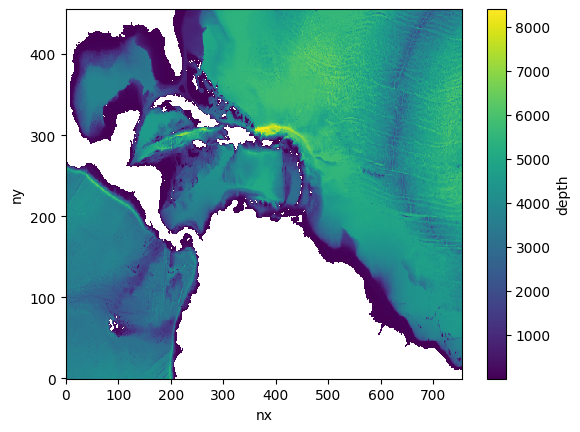

In [4]:
topo.depth.plot()

In [5]:
# Erase Pacific & Canada Bays
%matplotlib ipympl

from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

<Figure size 640x480 with 0 Axes>

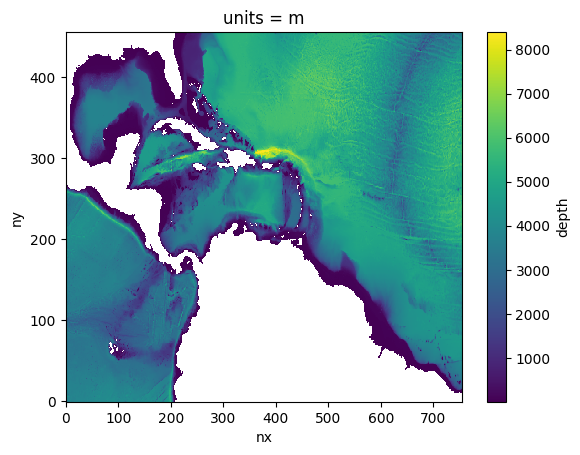

In [6]:
## Check bathymetry again after edits
import matplotlib.pyplot as plt

%matplotlib inline
plt.clf()
plt.figure()
topo.depth.plot()

## Vertical Grid

In [7]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 65,
    depth = topo.max_depth,
    ratio=99.48 # from Gio's paper 248.7/2.5=99.48
)

[  3.04371687   3.14589928   3.27013902   3.42116813   3.60471985
   3.82773372   4.09859952   4.4274458    4.82647885   5.31037754
   5.89674812   6.60664078   7.46512501   8.50191432   9.75201959
  11.25639499  13.06251859  15.22482047  17.80483499  20.87091074
  24.49726749  28.76215259  33.74483481  39.52120593  46.15786615
  53.70477681  62.18688471  71.59553516  81.88091921  92.94710902
 104.65125205 116.80807814 129.2        141.59192186 153.74874795
 165.45289098 176.51908079 186.80446484 196.21311529 204.69522319
 212.24213385 218.87879407 224.65516519 229.63784741 233.90273251
 237.52908926 240.59516501 243.17517953 245.33748141 247.14360501
 248.64798041 249.89808568 250.93487499 251.79335922 252.50325188
 253.08962246 253.57352115 253.9725542  254.30140048 254.57226628
 254.79528015 254.97883187 255.12986098 255.25410072 255.35628313]


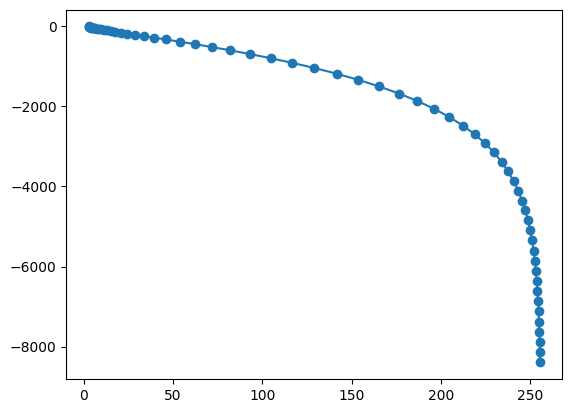

In [8]:
import numpy as np
print(vgrid.dz)
plt.plot(vgrid.dz,-np.cumsum(vgrid.dz),'o-')

## Creating the CESM Case

In [9]:
from pathlib import Path

# CESM case (experiment) name
casename = "CrocCaribDefault_Coarse"

# CESM source root (Update this path accordingly!!!)
cesmroot = '/glade/work/ajanney/CESM-versions/CROC_CESM' # Path.home() / "cesm3_0_beta04"
# I grabbed this version from Alper

# Place where all your input files go 
inputdir = Path("/glade/work/ajanney/CrocoDash_Input",casename) # Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path("/glade/work/ajanney/CESM/cases",casename) # Path.home() / "croc_cases" / casename

In [10]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'P93300012', # also can be unspecified if set by user config e.g. export PBS_ACCOUNT=P93300012
    override = True,
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "CrocCaribDefault_Coarse" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "CrocCaribDefault".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "CrocCaribDefault" with the following properties:
 nx: 756, ny: 456. ocean mesh: /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ESMF_mesh_CrocCaribDefault_377dcf.nc.

Running the create_newcase tool with the following command:

/glade/work/ajanney/CESM-versions/CROC_CESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res CrocCaribDefault_Coarse --case /glade/work/ajanney/CESM/cases/CrocCaribDefault_Coarse --machine derecho --run-unsupported --project P93300012 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/work/ajanney/CESM/cases/CrocCaribDefault_Coarse

App

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/work/ajanney/CESM/cases/CrocCaribDefault_Coarse.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



## Ocean Forcing Data from Glorys

In [11]:
case.configure_forcings(
    date_range = ["2000-01-01 00:00:00", "2020-02-01 00:00:00"],
    tidal_constituents = ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MM', 'MF'],
    tpxo_elevation_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/h_tpxo9.v1.nc", 
    # original: "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/h_tpxo9.v1.nc",
    tpxo_velocity_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/u_tpxo9.v1.nc" 
    # original: "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/u_tpxo9.v1.nc"
)

2025-02-24 18:43:41,205 - CrocoDash.data_access.driver.validate_function - ERROR - Error running function: module 'CrocoDash.rm6.regional_mom6' has no attribute 'get_glorys_data'


ERROR:CrocoDash.data_access.driver:Error running function: module 'CrocoDash.rm6.regional_mom6' has no attribute 'get_glorys_data'


ValueError: Selected Product or Function was not valid